In [53]:
# all imports come here
from faster_whisper import WhisperModel
import pandas as pd
import torch
import torchaudio
import pesto
from statistics import mean, median, mode
import openpyxl
import warnings
import numpy as np
import time

start = time.time()
warnings.filterwarnings("ignore")

In [55]:
# all major variables are here
model_size = "medium.en"
music_file_path = '/speech/dbwork/mul/spielwiese3/students/debaumas/datasets/tency_mastering_supervised_dry_wet_v2_22050_16bit/train/dry/0.wav'
sample_rate_speech = 16000
step_size_for_pitch = 10.
vad_threshold = 0.3 # speech probability - if more then speech else no speech
confidence_pesto = 0.1
num_sample = 10 # pesto computes 10 ms per sample so for a window of 100ms we need 10 samples as 10*10ms = 100ms
timestamp_for_sampling = step_size_for_pitch*num_sample/1000

In [56]:
# generate the modified start and the end times of the words said
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad', model='silero_vad')
(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils

wav = read_audio(music_file_path, sampling_rate=sample_rate_speech)
speech_timestamps = get_speech_timestamps(wav, model, sampling_rate=sample_rate_speech, threshold=vad_threshold)

total_datapoints = round(list(wav.shape)[0]/sample_rate_speech,0)

Using cache found in /home/desengus/.cache/torch/hub/snakers4_silero-vad_master


In [57]:
# Run on GPU with FP16
#model = WhisperModel(model_size, device="cuda", compute_type="float16")

# or run on GPU with INT8
faster_whisper_model = WhisperModel(model_size, compute_type='int8',device="cuda")
# or run on CPU with INT8
# model = WhisperModel(model_size, device="cpu", compute_type="int8")


In [58]:
tmp_x = len(speech_timestamps)
word_timings = pd.DataFrame(columns = ['start','end','words'])
start = []
end = []
words = []

for i in range(tmp_x):
#  print(i)
  save_audio('/speech/dbwork/mul/spielwiese4/students/desengus/'+music_file_path.split("/")[-1][:-4]+'.wav',
           wav[speech_timestamps[i]['start']:speech_timestamps[i]['end']], sampling_rate=sample_rate_speech)
  segments, _ = faster_whisper_model.transcribe('/speech/dbwork/mul/spielwiese4/students/desengus/'+music_file_path.split("/")[-1][:-4]+'.wav', word_timestamps=True)
  for segment in segments:
    for word in segment.words:
      start.append(round(word.start+speech_timestamps[i]['start']/sample_rate_speech,3))
      end.append(round(word.end+speech_timestamps[i]['end']/sample_rate_speech, 3))
      words.append(word.word)

      #print(round(word.start+speech_timestamps[i]['start']/sample_rate_speech,4), round(word.end+speech_timestamps[i]['end']/sample_rate_speech, 4), word.word)

word_timings['start'] = start
word_timings['end'] = end
word_timings['words'] = words


In [59]:
# predict the pitch of your audio tensors directly within your own Python code
audio, sample_rate = torchaudio.load(music_file_path)
audio = torchaudio.functional.resample(audio, orig_freq=sample_rate, new_freq=sample_rate_speech)
timesteps, pitch, confidence, activations = pesto.predict(audio, sample_rate_speech, step_size=step_size_for_pitch)


In [60]:
sample_rate

22050

In [61]:
sample_rate_speech

16000

In [62]:
word_timings

,start,end,words
0,14.818,18.790,I've
1,15.178,19.030,been
2,15.418,19.350,looking
3,15.738,19.730,at
4,16.118,20.370,"you,"
...,...,...,...
248,165.794,166.862,Oh
249,165.874,167.002,"shit,"
250,166.194,167.182,an
251,166.194,167.402,old


In [63]:
timesteps_result = [round(tensor.item(),2) for tensor in timesteps]
pitch_result = [round(tensor.item(),4) for tensor in pitch]
confidence_result = [round(tensor.item(),4) for tensor in confidence]
df_pitch = pd.DataFrame([timesteps_result,pitch_result,confidence_result])
df_pitch = df_pitch.T
df_pitch.columns = ['timesteps','pitch','confidence']

In [64]:
df_pitch

,timesteps,pitch,confidence
0,0.00,61.6667,0.0
1,0.01,61.6667,0.0
2,0.02,61.6667,0.0
3,0.03,61.6667,0.0
4,0.04,61.6667,0.0
...,...,...,...
18797,187.97,61.6667,0.0
18798,187.98,61.6667,0.0
18799,187.99,61.6667,0.0
18800,188.00,61.6667,0.0


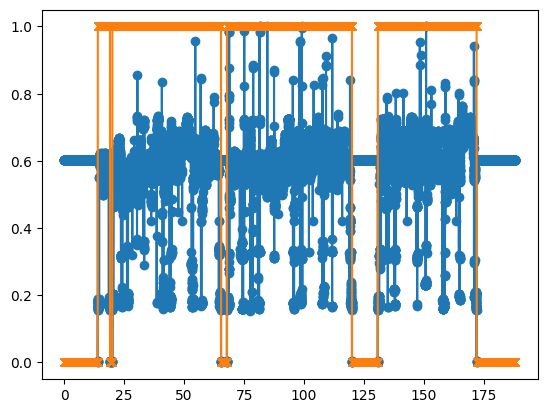

In [65]:
# just for info

import matplotlib.pyplot as plt

df_pitch['pitch_norm']= (df_pitch['pitch'] - df_pitch['pitch'].min()) / (df_pitch['pitch'].max() - df_pitch['pitch'].min())
df_pitch['confidence_norm'] = (df_pitch['confidence'] - df_pitch['confidence'].min()) / (df_pitch['confidence'].max() - df_pitch['confidence'].min())


plt.plot(df_pitch['timesteps'], df_pitch['pitch_norm'], label='Data 1', marker='o')
plt.plot(df_pitch['timesteps'], df_pitch['confidence_norm']>0.1, label='Data 2', marker='x')


In [66]:
(df_pitch['confidence_norm'] > 0.2).mean() * 100

76.40144665461122

In [67]:
# df_pitch = df_pitch[df_pitch['confidence_norm'] >= confidence_pesto]
# df_pitch = df_pitch.reset_index(drop=True)

In [68]:
# set the end based on the start of the next word such that there is no overlap
for i in range(len(word_timings) - 1):
    if word_timings.at[i, 'end'] > word_timings.at[i + 1, 'start']:
        word_timings.at[i, 'end'] = word_timings.at[i + 1, 'start']



In [69]:
word_timings

,start,end,words
0,14.818,15.178,I've
1,15.178,15.418,been
2,15.418,15.738,looking
3,15.738,16.118,at
4,16.118,17.038,"you,"
...,...,...,...
248,165.794,165.874,Oh
249,165.874,166.194,"shit,"
250,166.194,166.194,an
251,166.194,166.414,old


In [70]:
word_timings['start'] = round(word_timings['start'],1)
word_timings['end'] = round(word_timings['end'],1)
word_timings['pitches'] = pd.Series(dtype='object')
word_timings['mean_pitches'] = pd.Series(dtype='object')
word_timings['median_pitches'] = pd.Series(dtype='object')
word_timings['mode_pitches'] = pd.Series(dtype='object')
word_timings['samples'] = (word_timings['end']-word_timings['start'])/timestamp_for_sampling
word_timings['samples'] = word_timings['samples'].round(0).astype('int')
word_timings['act_start'] = pd.Series(dtype='object')
word_timings['act_end'] = pd.Series(dtype='object')
word_timings['word_index'] = word_timings.index+1
word_timings['word_index'] = word_timings['word_index'].astype(str)

In [71]:
word_timings['word_index']

0        1
1        2
2        3
3        4
4        5
      ... 
248    249
249    250
250    251
251    252
252    253
Name: word_index, Length: 253, dtype: object

In [72]:
# Duplicate rows based on the 'Value' column
word_timings_expanded = word_timings.loc[word_timings.index.repeat(word_timings['samples'])]

# Reset index to get a new DataFrame with duplicated rows
word_timings_expanded = word_timings_expanded.reset_index(drop=True)

In [73]:
word_timings_expanded.shape[0]

1412

In [74]:
tmp_start = word_timings_expanded['start'][0]
word_timings_expanded['act_start'][0] = tmp_start
word_timings_expanded['act_end'][0] = tmp_start + timestamp_for_sampling
for i in range(1,word_timings_expanded.shape[0]):
    if tmp_start == word_timings_expanded['start'][i]:
        word_timings_expanded['act_start'][i] = (word_timings_expanded['act_end'][i-1]).round(1)
        word_timings_expanded['act_end'][i] = (word_timings_expanded['act_start'][i]+timestamp_for_sampling).round(1)
    else:
        tmp_start = word_timings_expanded['start'][i]
        word_timings_expanded['act_start'][i] = (tmp_start).round(1)
        word_timings_expanded['act_end'][i] = (word_timings_expanded['act_start'][i]+timestamp_for_sampling).round(1)

In [75]:
word_timings_expanded

,start,end,words,pitches,mean_pitches,median_pitches,mode_pitches,samples,act_start,act_end,word_index
0,14.8,15.2,I've,NaN,NaN,NaN,NaN,4,14.8,14.9,1
1,14.8,15.2,I've,NaN,NaN,NaN,NaN,4,14.9,15.0,1
2,14.8,15.2,I've,NaN,NaN,NaN,NaN,4,15.0,15.1,1
3,14.8,15.2,I've,NaN,NaN,NaN,NaN,4,15.1,15.2,1
4,15.2,15.4,been,NaN,NaN,NaN,NaN,2,15.2,15.3,2
...,...,...,...,...,...,...,...,...,...,...,...
1407,166.4,167.7,guy!,NaN,NaN,NaN,NaN,13,167.2,167.3,253
1408,166.4,167.7,guy!,NaN,NaN,NaN,NaN,13,167.3,167.4,253
1409,166.4,167.7,guy!,NaN,NaN,NaN,NaN,13,167.4,167.5,253
1410,166.4,167.7,guy!,NaN,NaN,NaN,NaN,13,167.5,167.6,253


In [76]:
df_pitch['timesteps']

0          0.00
1          0.01
2          0.02
3          0.03
4          0.04
          ...  
18797    187.97
18798    187.98
18799    187.99
18800    188.00
18801    188.01
Name: timesteps, Length: 18802, dtype: float64

In [77]:
for i in range(word_timings_expanded.shape[0]):
  start = word_timings_expanded['act_start'][i]
  end = word_timings_expanded['act_end'][i]
  pitch = []
  #print(i)
  for j in range(df_pitch.shape[0]):
    if start <= df_pitch['timesteps'][j] <= end:
      pitch.append(df_pitch['pitch'][j])
  word_timings_expanded['pitches'][i] = pitch



In [ ]:
word_timings_expanded[45:46]['act_end']

45    19.4
Name: act_end, dtype: object

In [78]:
for i in range(word_timings_expanded.shape[0]):
  #print(i)
  if word_timings_expanded['pitches'][i] ==[]:
    word_timings_expanded['mean_pitches'][i] = 0
    word_timings_expanded['median_pitches'][i] = 0
    word_timings_expanded['mode_pitches'][i] = 0
  else:
    word_timings_expanded['mean_pitches'][i] = mean(word_timings_expanded['pitches'][i])
    word_timings_expanded['median_pitches'][i] = median(word_timings_expanded['pitches'][i])
    word_timings_expanded['mode_pitches'][i] = mode(word_timings_expanded['pitches'][i])

In [79]:
word_timings_expanded

,start,end,words,pitches,mean_pitches,median_pitches,mode_pitches,samples,act_start,act_end,word_index
0,14.8,15.2,I've,"[61.0, 61.0, 61.0, 60.6667, 60.6667, 61.0, 61....",61.212127,61.0,61.0,4,14.8,14.9,1
1,14.8,15.2,I've,"[62.0, 62.3333, 62.6667, 63.0, 63.0, 63.0, 63....",62.818182,63.0,63.0,4,14.9,15.0,1
2,14.8,15.2,I've,"[62.6667, 62.3333, 62.3333, 62.0, 61.3333, 60....",61.545455,62.0,62.6667,4,15.0,15.1,1
3,14.8,15.2,I've,"[62.6667, 62.6667, 63.0, 63.0, 63.0, 63.0, 63....",62.9394,63.0,63.0,4,15.1,15.2,1
4,15.2,15.4,been,"[63.0, 63.0, 63.0, 63.0, 63.0, 63.0, 63.0, 63....",63.0,63.0,63.0,2,15.2,15.3,2
...,...,...,...,...,...,...,...,...,...,...,...
1407,166.4,167.7,guy!,"[71.0, 70.6667, 70.6667, 70.6667, 70.6667, 70....",70.697,70.6667,70.6667,13,167.2,167.3,253
1408,166.4,167.7,guy!,"[70.6667, 70.6667, 70.6667, 71.0, 71.0, 71.0, ...",70.9091,71.0,71.0,13,167.3,167.4,253
1409,166.4,167.7,guy!,"[71.0, 71.0, 71.0, 71.0, 71.0, 71.0, 71.0, 71....",71.0,71.0,71.0,13,167.4,167.5,253
1410,166.4,167.7,guy!,"[71.0, 71.0, 71.3333, 71.3333, 71.0, 71.0, 71....",71.0606,71.0,71.0,13,167.5,167.6,253


In [80]:
node_ds = pd.DataFrame()
node_ds['Note'] = ['0','C0','C0#','D0','D0#','E0','F0','F0#','G0','G0#','A0','A0#','B0',
                   'C1','C1#','D1','D1#','E1','F1','F1#','G1','G1#','A1','A1#','B1',
                   'C2','C2#','D2','D2#','E2','F2','F2#','G2','G2#','A2','A2#','B2',
                   'C3','C3#','D3','D3#','E3','F3','F3#','G3','G3#','A3','A3#','B3',
                   'C4','C4#','D4','D4#','E4','F4','F4#','G4','G4#','A4','A4#','B4',
                   'C5','C5#','D5','D5#','E5','F5','F5#','G5','G5#','A5','A5#','B5',
                   'C6','C6#','D6','D6#','E6','F6','F6#','G6','G6#','A6','A6#','B6',
                   'C7','C7#','D7','D7#','E7','F7','F7#','G7','G7#','A7','A7#','B7',
                   'C8','C8#','D8','D8#','E8','F8','F8#','G8','G8#','A8','A8#','B8']
node_ds['Frequency'] = [0, 16.35, 17.32, 18.35, 19.45, 20.60, 21.83, 23.12, 24.50,
                             25.96, 27.50, 29.14, 30.87, 32.70, 34.65, 36.71, 38.89,
                             41.20, 43.65, 46.25, 49.00, 51.91, 55.00, 58.27, 61.74,
                             65.41, 69.30, 73.42, 77.78, 82.41, 87.31, 92.50, 98.00,
                             103.83, 110.00, 116.54, 123.47, 130.81, 138.59, 146.83,
                             155.56, 164.81, 174.61, 185.00, 196.00, 207.65, 220.00,
                             233.08, 246.94, 261.63, 277.18, 293.66, 311.13, 329.63,
                             349.23, 369.99, 392.00, 415.30, 440.00, 466.16, 493.88,
                             523.25, 554.37, 587.33, 622.25, 659.25, 698.46, 739.99,
                             783.99, 830.61, 880.00, 932.33, 987.77, 1046.50, 1108.73,
                             1174.66, 1244.51, 1318.51, 1396.91, 1479.98, 1567.98,
                             1661.22, 1760.00, 1864.66, 1975.53, 2093.00, 2217.46, 2349.32,
                             2489.02, 2637.02, 2793.83, 2959.96, 3135.96, 3322.44, 3520.00,
                             3729.31, 3951.07, 4186.01, 4434.92, 4698.63, 4978.03, 5274.04,
                             5587.65, 5919.91, 6271.93, 6644.88, 7040.00, 7458.62, 7902.13]

In [81]:
word_timings_expanded['mean_node'] = pd.Series(dtype = 'object')
word_timings_expanded['median_node'] = pd.Series(dtype = 'object')
word_timings_expanded['mode_node'] = pd.Series(dtype = 'object')

for i in range(word_timings_expanded.shape[0]):
  mean_s = min(range(len(node_ds['Frequency'])), key=lambda j: abs(node_ds['Frequency'][j]-word_timings_expanded['mean_pitches'][i]))
  word_timings_expanded['mean_node'][i] = node_ds['Note'][mean_s]
  median_s = min(range(len(node_ds['Frequency'])), key=lambda k: abs(node_ds['Frequency'][k]-word_timings_expanded['median_pitches'][i]))
  word_timings_expanded['median_node'][i] = node_ds['Note'][median_s]
  mode_s = min(range(len(node_ds['Frequency'])), key=lambda l: abs(node_ds['Frequency'][l]-word_timings_expanded['mode_pitches'][i]))
  word_timings_expanded['mode_node'][i] = node_ds['Note'][mode_s]

In [82]:
word_timings_expanded

,start,end,words,pitches,mean_pitches,median_pitches,mode_pitches,samples,act_start,act_end,word_index,mean_node,median_node,mode_node
0,14.8,15.2,I've,"[61.0, 61.0, 61.0, 60.6667, 60.6667, 61.0, 61....",61.212127,61.0,61.0,4,14.8,14.9,1,B1,B1,B1
1,14.8,15.2,I've,"[62.0, 62.3333, 62.6667, 63.0, 63.0, 63.0, 63....",62.818182,63.0,63.0,4,14.9,15.0,1,B1,B1,B1
2,14.8,15.2,I've,"[62.6667, 62.3333, 62.3333, 62.0, 61.3333, 60....",61.545455,62.0,62.6667,4,15.0,15.1,1,B1,B1,B1
3,14.8,15.2,I've,"[62.6667, 62.6667, 63.0, 63.0, 63.0, 63.0, 63....",62.9394,63.0,63.0,4,15.1,15.2,1,B1,B1,B1
4,15.2,15.4,been,"[63.0, 63.0, 63.0, 63.0, 63.0, 63.0, 63.0, 63....",63.0,63.0,63.0,2,15.2,15.3,2,B1,B1,B1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407,166.4,167.7,guy!,"[71.0, 70.6667, 70.6667, 70.6667, 70.6667, 70....",70.697,70.6667,70.6667,13,167.2,167.3,253,C2#,C2#,C2#
1408,166.4,167.7,guy!,"[70.6667, 70.6667, 70.6667, 71.0, 71.0, 71.0, ...",70.9091,71.0,71.0,13,167.3,167.4,253,C2#,C2#,C2#
1409,166.4,167.7,guy!,"[71.0, 71.0, 71.0, 71.0, 71.0, 71.0, 71.0, 71....",71.0,71.0,71.0,13,167.4,167.5,253,C2#,C2#,C2#
1410,166.4,167.7,guy!,"[71.0, 71.0, 71.3333, 71.3333, 71.0, 71.0, 71....",71.0606,71.0,71.0,13,167.5,167.6,253,C2#,C2#,C2#


In [83]:
song_length = round(list(audio.shape)[1]/sample_rate_speech,2) # song length in sec

In [84]:
start_values = np.arange(0, song_length, timestamp_for_sampling)
end_values = start_values + 0.1

df = pd.DataFrame({'act_start': start_values, 'act_end': end_values})

# Display the DataFrame
print(df)


      act_start  act_end
0           0.0      0.1
1           0.1      0.2
2           0.2      0.3
3           0.3      0.4
4           0.4      0.5
...         ...      ...
1876      187.6    187.7
1877      187.7    187.8
1878      187.8    187.9
1879      187.9    188.0
1880      188.0    188.1

[1881 rows x 2 columns]


In [96]:
song_length

188.01

In [85]:
# word_timings_expanded['act_start'].round(1)

In [86]:
word_timings_expanded[0:10]['act_start']
word_timings_expanded[0:10]['act_end']

0    14.9
1    15.0
2    15.1
3    15.2
4    15.3
5    15.4
6    15.5
7    15.6
8    15.7
9    15.8
Name: act_end, dtype: object

In [87]:
df[0:1]['act_end']


0    0.1
Name: act_end, dtype: float64

In [88]:
word_timings_expanded['act_end'] = word_timings_expanded['act_end'].astype(float).round(1)
word_timings_expanded['act_start'] = word_timings_expanded['act_start'].astype(float).round(1)
df['act_end'] = df['act_end'].astype(float).round(1)
df['act_start'] = df['act_start'].astype(float).round(1)


merged_df = pd.merge(word_timings_expanded, df, on =['act_start', 'act_end'], how = 'right')

In [89]:
merged_df[1650:1700]

,start,end,words,pitches,mean_pitches,median_pitches,mode_pitches,samples,act_start,act_end,word_index,mean_node,median_node,mode_node
1650,163.3,165.1,boy!,"[68.3333, 68.6667, 57.0, 68.6667, 68.6667, 68....",63.121218,67.6667,68.6667,18.0,165.0,165.1,244,B1,C2#,C2#
1651,165.1,165.4,I'm,"[57.3333, 57.6667, 59.0, 59.3333, 59.0, 59.333...",59.909073,59.3333,59.0,3.0,165.1,165.2,245,A1#,A1#,A1#
1652,165.1,165.4,I'm,"[63.3333, 64.0, 64.3333, 65.0, 65.3333, 65.666...",65.545445,65.6667,63.3333,3.0,165.2,165.3,245,C2,C2,B1
1653,165.1,165.4,I'm,"[67.3333, 67.6667, 68.3333, 69.6667, 70.0, 70....",69.696973,70.0,70.0,3.0,165.3,165.4,245,C2#,C2#,C2#
1654,165.4,165.5,in,"[71.0, 71.3333, 71.3333, 71.3333, 71.3333, 71....",71.2424,71.3333,71.3333,1.0,165.4,165.5,246,C2#,C2#,C2#
1655,165.5,165.6,a,"[71.0, 71.0, 71.0, 71.0, 71.0, 71.0, 71.3333, ...",71.0303,71.0,71.0,1.0,165.5,165.6,247,C2#,C2#,C2#
1656,165.6,165.8,-,"[71.0, 71.0, 71.0, 71.0, 71.0, 71.0, 71.3333, ...",71.424236,71.0,71.0,2.0,165.6,165.7,248,D2,C2#,C2#
1657,165.6,165.8,-,"[73.0, 73.6667, 74.3333, 74.3333, 74.3333, 74....",73.1212,73.6667,74.3333,2.0,165.7,165.8,248,D2,D2,D2
1658,165.8,165.9,Oh,"[70.3333, 69.3333, 68.6667, 66.0, 65.6667, 65....",67.515155,67.6667,68.6667,1.0,165.8,165.9,249,C2#,C2#,C2#
1659,165.9,166.2,"shit,","[68.0, 67.6667, 68.3333, 68.6667, 68.6667, 68....",68.212118,68.3333,68.0,3.0,165.9,166.0,250,C2#,C2#,C2#


In [90]:
col_to_drop = ['start','end','pitches','mean_pitches','median_pitches','mode_pitches', 'samples']

df = merged_df.drop(columns=col_to_drop)

In [91]:
df

,words,act_start,act_end,word_index,mean_node,median_node,mode_node
0,NaN,0.0,0.1,NaN,NaN,NaN,NaN
1,NaN,0.1,0.2,NaN,NaN,NaN,NaN
2,NaN,0.2,0.3,NaN,NaN,NaN,NaN
3,NaN,0.3,0.4,NaN,NaN,NaN,NaN
4,NaN,0.4,0.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1876,NaN,187.6,187.7,NaN,NaN,NaN,NaN
1877,NaN,187.7,187.8,NaN,NaN,NaN,NaN
1878,NaN,187.8,187.9,NaN,NaN,NaN,NaN
1879,NaN,187.9,188.0,NaN,NaN,NaN,NaN


In [92]:
df['words'] = df['words'].fillna('[silence]')
df['word_index'] = df['word_index'].fillna('[silence]')
df['mean_node'] = df['mean_node'].fillna('0')
df['median_node'] = df['median_node'].fillna('0')
df['mode_node'] = df['mode_node'].fillna('0')


In [93]:
df

,words,act_start,act_end,word_index,mean_node,median_node,mode_node
0,[silence],0.0,0.1,[silence],0,0,0
1,[silence],0.1,0.2,[silence],0,0,0
2,[silence],0.2,0.3,[silence],0,0,0
3,[silence],0.3,0.4,[silence],0,0,0
4,[silence],0.4,0.5,[silence],0,0,0
...,...,...,...,...,...,...,...
1876,[silence],187.6,187.7,[silence],0,0,0
1877,[silence],187.7,187.8,[silence],0,0,0
1878,[silence],187.8,187.9,[silence],0,0,0
1879,[silence],187.9,188.0,[silence],0,0,0


In [94]:
# Grouping based on intervals of 200 indexes
# Concatenate other columns within each group
result_df = df.groupby(df.index//20).agg({
    'words': lambda x: ' ; '.join(pd.unique(x)),
    'word_index': ' ; '.join,
    'mean_node': ' ; '.join,
    'median_node': ' ; '.join,
    'mode_node': ' ; '.join
}).reset_index(drop=True)

In [95]:
result_df[80:]

,words,word_index,mean_node,median_node,mode_node
80,"and ; me ; could ; give ; it ; a ; whirl,",233 ; 233 ; 233 ; 234 ; 234 ; 234 ; 235 ; 235 ...,C2 ; C2 ; C2 ; C2 ; C2# ; B1 ; A1# ; A1# ; A1#...,C2 ; C2 ; C2 ; C2 ; C2# ; C2 ; A1# ; A1# ; A1#...,C2 ; C2 ; C2 ; C2 ; C2# ; A1# ; A1# ; A1# ; A1...
81,"whirl, ; but ; I'm ; wantin' ; you ; boy!",239 ; 239 ; 239 ; 240 ; 241 ; 241 ; 241 ; 242 ...,C2 ; A1# ; A1# ; A1# ; A1# ; A1# ; A1# ; B1 ; ...,C2 ; A1# ; A1# ; A1# ; A1# ; A1# ; A1# ; B1 ; ...,C2# ; A1# ; A1# ; A1# ; A1# ; A1# ; A1# ; B1 ;...
82,"boy! ; I'm ; in ; a ; - ; Oh ; shit,",244 ; 244 ; 244 ; 244 ; 244 ; 244 ; 244 ; 244 ...,C2 ; C2 ; C2# ; C2 ; A1# ; A1# ; A1# ; C1 ; B0...,C2 ; C2 ; C2# ; A1# ; A1# ; A1# ; A1# ; A0# ; ...,C2 ; C2 ; C2# ; C2# ; A1 ; A1# ; A1# ; A0# ; A...
83,"shit, ; old ; guy! ; [silence]",250 ; 250 ; 252 ; 252 ; 253 ; 253 ; 253 ; 253 ...,C2# ; C2# ; C2# ; C2# ; C2# ; C2# ; C2# ; C2# ...,C2# ; C2# ; C2# ; C2# ; C2# ; C2# ; C2# ; C2# ...,C2# ; C2# ; C2# ; C2# ; C2# ; C2# ; C2# ; C2# ...
84,[silence],[silence] ; [silence] ; [silence] ; [silence] ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
85,[silence],[silence] ; [silence] ; [silence] ; [silence] ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
86,[silence],[silence] ; [silence] ; [silence] ; [silence] ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
87,[silence],[silence] ; [silence] ; [silence] ; [silence] ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
88,[silence],[silence] ; [silence] ; [silence] ; [silence] ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
89,[silence],[silence] ; [silence] ; [silence] ; [silence] ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...


In [ ]:
for i in range(result_df.shape[0]-1):
    p = result_df['words'][i].split(' ; ')
    q = result_df['words'][i+1].split(' ; ')
#    print(p)
 #   print(q)
    if p[-1]==q[0] and p[-1]!='[silence]':
        print(q)
        q = q[1:]
        result_df['words'][i+1] = ' ; '.join(q)
        print(result_df['words'][i+1])


[' at', ' you,', ' looking', ' me.']
 you, ;  looking ;  me.
[' me.']

[" thinkin'", ' what', ' you', ' get']
 what ;  you ;  get
[' get', ' Is', ' what', ' you', ' say']
 Is ;  what ;  you ;  say
[' say', ' But', ' underneath', ' this']
 But ;  underneath ;  this
[' this', ' cool', ' exterior']
 cool ;  exterior
[' exterior', ' A', ' raging', ' river']
 A ;  raging ;  river
[' nearer,', ' I', ' better', ' let', ' you', ' know!']
 I ;  better ;  let ;  you ;  know!
[' know!', ' AMEN', ' emotional', ' girl']
 AMEN ;  emotional ;  girl
[' girl', ' I', " can't"]
 I ;  can't
[" can't", ' help', ' myself']
 help ;  myself
[' myself', ' Sometimes', ' I']
 Sometimes ;  I
[' I', ' laugh,', ' sometimes', ' cry,']
 laugh, ;  sometimes ;  cry,
[' cry,', ' sometimes', ' I', ' do,', ' then', " don't"]
 sometimes ;  I ;  do, ;  then ;  don't
[" don't", ' know', ' Passionate']
 know ;  Passionate
[' Passionate', ' heart!', ' And']
 heart! ;  And
[' And', " that's", ' just', ' the', ' way', ' things']

In [ ]:
result_df[80:]

,words,word_index,mean_node,median_node,mode_node
80,"me ; could ; give ; it ; a ; whirl,",233 ; 233 ; 233 ; 234 ; 234 ; 234 ; 235 ; 235 ...,C2 ; C2 ; C2 ; C2 ; C2# ; B1 ; A1# ; A1# ; A1#...,C2 ; C2 ; C2 ; C2 ; C2# ; C2 ; A1# ; A1# ; A1#...,C2 ; C2 ; C2 ; C2 ; C2# ; A1# ; A1# ; A1# ; A1...
81,but ; I'm ; wantin' ; you ; boy!,239 ; 239 ; 239 ; 240 ; 241 ; 241 ; 241 ; 242 ...,C2 ; A1# ; A1# ; A1# ; A1# ; A1# ; A1# ; B1 ; ...,C2 ; A1# ; A1# ; A1# ; A1# ; A1# ; A1# ; B1 ; ...,C2# ; A1# ; A1# ; A1# ; A1# ; A1# ; A1# ; B1 ;...
82,"I'm ; in ; a ; - ; Oh ; shit,",244 ; 244 ; 244 ; 244 ; 244 ; 244 ; 244 ; 244 ...,C2 ; C2 ; C2# ; C2 ; A1# ; A1# ; A1# ; C1 ; B0...,C2 ; C2 ; C2# ; A1# ; A1# ; A1# ; A1# ; A0# ; ...,C2 ; C2 ; C2# ; C2# ; A1 ; A1# ; A1# ; A0# ; A...
83,old ; guy! ; [silence],250 ; 250 ; 252 ; 252 ; 253 ; 253 ; 253 ; 253 ...,C2# ; C2# ; C2# ; C2# ; C2# ; C2# ; C2# ; C2# ...,C2# ; C2# ; C2# ; C2# ; C2# ; C2# ; C2# ; C2# ...,C2# ; C2# ; C2# ; C2# ; C2# ; C2# ; C2# ; C2# ...
84,[silence],[silence] ; [silence] ; [silence] ; [silence] ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
85,[silence],[silence] ; [silence] ; [silence] ; [silence] ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
86,[silence],[silence] ; [silence] ; [silence] ; [silence] ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
87,[silence],[silence] ; [silence] ; [silence] ; [silence] ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
88,[silence],[silence] ; [silence] ; [silence] ; [silence] ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
89,[silence],[silence] ; [silence] ; [silence] ; [silence] ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...


In [ ]:
#result_df.to_excel('/speech/dbwork/mul/spielwiese4/students/desengus/excels/train/0.xlsx')

In [ ]:
type(result_df['word_index'][0])

str

In [ ]:
import pandas as pd

# Sample DataFrame
df = pd.DataFrame({
    'group_col': ['A', 'A', 'B', 'B', 'C', 'C', 'C', 'D', 'D', 'D'],
    'words': ['apple', 'banana', 'apple', 'banana', 'apple', 'orange', 'apple', 'banana', 'cherry', 'orange'],
    'word_index': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'mean_node': [10, 20, 15, 25, 30, 35, 40, 45, 50, 55],
    'median_node': [11, 21, 16, 26, 31, 36, 41, 46, 51, 56],
    'mode_node': [12, 22, 17, 27, 32, 37, 42, 47, 52, 57]
})

# Group by 'group_col'
grouped = df.groupby('group_col')

# Concatenate other columns within each group
result_df = grouped.agg({
    'words': lambda x: ', '.join(pd.unique(x)),
    'word_index': lambda x: ' , '.join(map(str, x)),
    'mean_node': lambda x: ' , '.join(map(str, x)),
    'median_node': lambda x: ' , '.join(map(str, x)),
    'mode_node': lambda x: ' , '.join(map(str, x))
}).reset_index()

# Display the resulting DataFrame
print(result_df)


  group_col                   words  word_index     mean_node   median_node  \
0         A           apple, banana       1 , 2       10 , 20       11 , 21   
1         B           apple, banana       3 , 4       15 , 25       16 , 26   
2         C           apple, orange   5 , 6 , 7  30 , 35 , 40  31 , 36 , 41   
3         D  banana, cherry, orange  8 , 9 , 10  45 , 50 , 55  46 , 51 , 56   

      mode_node  
0       12 , 22  
1       17 , 27  
2  32 , 37 , 42  
3  47 , 52 , 57  


In [ ]:
print(start - time.time())